<a href="https://colab.research.google.com/github/CAVA1611/neural-networks/blob/tcn/TFM_Reddit_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción con Series Temporales de la carga en un centro de datos

**Autor:** Cesar Velasco Arias

In [3]:
# Importacion de librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import os
from time import sleep
import re 

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, Dropout
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
import tensorflow as tf
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(80)
random.seed(80)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)




/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
path = '/content/drive/MyDrive/TFM/csv_2019'
year = '2019'

In [5]:

def files_verification():
  meses = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
  list_dir=[]
  files_to_read=[]
  files_not_found=[] 
  count = 0 
  try:
    list_dir = os.listdir(path)
    if os.path.isdir(path) and len(list_dir)>0:
      for mes in meses:
        file_to_read = 'LoadReddit-60minutes-'+ str(year)+'-'+ str(mes)+'-PLN.csv'
        if os.path.isfile(os.path.join(path, file_to_read)):
            count+=1
            files_to_read.append(file_to_read)
        else:
          files_not_found.append(file_to_read)
  except:  
    print('No se ha encontrado el directorio')
  
  print('Se han encontrado: {} correspondientes al año {}'.format(count,year))
  for f in files_to_read:
    print('-',f)
  print('\nHace falta {} archivos'.format(12-count))
  for nf in files_not_found:
    print('-',nf)
  print('\n')
  return files_to_read

In [6]:

def data_reading(path, year):
  global df
  meses = {'enero': '01', 'febrero':'02', 'marzo':'03', 'abril':'04', 'mayo':'05', 
           'junio':'06', 'julio':'07', 'agosto':'08','septiembre':'09',
           'octubre':'10', 'noviembre':'11', 'diciembre':'12'}
  month_conc = []
  flag_marzo = False
  files_to_read = files_verification()    
  for mes_k, mes_v in zip(meses.keys(), meses.values()):
    if mes_k == 'marzo':
      flag_marzo = True
    for file in files_to_read:
      pa = file.split('-')
      for p in pa:
        if p == mes_v:
          mes_k = pd.read_csv(os.path.join(path, file), 
                              header=None, names=['Date', 'number_of_post'], 
                              parse_dates=['Date']) 
          
          if flag_marzo:
            print("Arreglo de error")
            mes_k.loc[mes_k.number_of_post == 1751610, 'number_of_post'] = 227000
            flag_marzo = False
          month_conc.append(mes_k)
          #print('Dimension para el mes {}: {}'.format(mes_k,mes_k.shape))
  df = pd.concat(month_conc, axis=0)
  print('*'*30)
  print('\nDimension de df -> ',df.shape)

  return (df, meses)

In [7]:
def graphic_1(start_month,end_month,year):
  global df_time, train_scaler, test_scaler, steps
  
  df_time, meses = data_reading(path, year)
  df_time = df_time.set_index('Date')
  for mes_k, mes_v in zip(meses.keys(), meses.values()):
    if start_month == mes_k:
      start_month_index = mes_v
  for mes_k, mes_v in zip(meses.keys(), meses.values()):
    if end_month == mes_k:
      end_month_index = mes_v
  if start_month_index > end_month_index:
    print("Mal ingreso de mes, el mes de inicio no puede ser despues del segundo")
  else:
    print("Datos para graficar desde {} hasta {}".format(start_month, end_month))
    steps = int(len(df_time)*0.2)
    train = df_time[:-steps]
    test  = df_time[-steps:]
    max = train.max()
    min = train.min()
    train_scaler=  train['number_of_post'].apply(lambda x: (x-min)/(max-min))
    test_scaler= test['number_of_post'].apply(lambda x: (x-min)/(max-min)) 
    fig, (ax1, ax2)=plt.subplots(2, figsize=(20, 8))
    df_time.plot(ax=ax1, grid=True)
    train_scaler.plot(ax=ax2, grid=True)
    test_scaler.plot(ax=ax2, grid=True)
    ax1.legend(['Datos'])
    ax2.legend(['Train', 'Test'])
    ax1.set_title('Datos Originales')
    ax2.set_title('Datos Normalizados')
    plt.subplots_adjust(hspace=0.8)
  


In [8]:
def data_for_rn(df_train, df_test, n_obs):
  #n_obs -> es el numero de observacione que se toman para predecir un valor
  # Con los datos de train se debe dividir en un array "X_train" y  "y_train"; este es un formato necesario para la prediccion en series
  # temporales. En "X_train" se encontaran el numero de observaciones que leera el modelo para predecir y en "y_train" se encontrara
  # el valor a predecir. 
  # Ambos tendran la misma dimension en cuanto a numero de filas.
  # Para el caso de este trabajo se ha escogido como numero de observaciones 20, es decir que se leeran 20 datos para predecir 1

  Obs = n_obs
  X_train = np.atleast_3d(np.array([df_train[start:start + Obs] for start in range(0, df_train.shape[0] - Obs)]))
  y_train = df_train[Obs:]

  # Para probar el modelo entrenado con los datos de test se tiene que colocar en el mismo formato.
  X_test = np.atleast_3d(np.array([df_test[start:start + Obs] for start in range(0, df_test.shape[0] - Obs)]))
  y_test = df_test[Obs:]
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
  
  return (X_train, y_train, X_test, y_test)


  

In [9]:
def graphic_predict(df_predicted):
  #grafico de los valores de test y los valores predichos 
  fig, (ax1, ax2)=plt.subplots(2, figsize=(20, 8))
  train_scaler.plot(ax=ax1, grid=True)
  test_scaler.plot(ax=ax1, grid=True)
  df_predicted.plot(ax=ax1, grid=True)
  ax1.legend(['Train', 'Test', 'Test Predict'])
  ax1.set_title('DATOS CON LA PREDICCION ')
  test_scaler.plot(ax=ax2, grid=True)
  df_predicted.plot(ax=ax2, grid=True)
  ax2.legend(['Test', 'Test Predict'])
  ax2.set_title('MES DE PREDICCION')
  plt.subplots_adjust(hspace=0.8)
  

In [47]:
def prediction(modelo, X_test):
  layers=[]
  
  test_pred = modelo.predict(X_test)
  for layer in modelo.layers:
    layers.append(layer.name)
  if len(layers) == 2:
    n_neur = modelo.layers[0].get_output_shape_at(0)
    name = layers[0].split('_')
    RESULTADOS.loc['Modelo 1 capa '+ name[0] + '-' + str(n_neur[1])] = (math.sqrt(mean_squared_error(y_test, test_pred)))
  elif len(layers) == 3:
    n_neur = modelo.layers[1].get_output_shape_at(0)
    name = layers[1].split('_')
    RESULTADOS.loc['Modelo 1 capa '+ name[0] + '-' + str(n_neur[1])] = (math.sqrt(mean_squared_error(y_test, test_pred)))
    if name[0] == 'gru':
      name = layers[0].split('_')
      name_2 = layers[1].split('_')
      n_neur = modelo.layers[0].get_output_shape_at(0)
      n_neur_2 = modelo.layers[1].get_output_shape_at(0)
      RESULTADOS.loc['Modelo 2 capas '+ name[0] + str(n_neur[2]) + '+' + name_2[0] + '-' + str(n_neur_2[1])] = (math.sqrt(mean_squared_error(y_test, test_pred)))
  elif len(layers) == 4:
    name = layers[1].split('_')
    name_2 = layers[2].split('_')
    n_neur = modelo.layers[1].get_output_shape_at(0)
    n_neur_2 = modelo.layers[2].get_output_shape_at(0)
    RESULTADOS.loc['Modelo 2 capas '+ name[0] + str(n_neur[2]) + '+' + name_2[0] + '-' + str(n_neur_2[1])] = (math.sqrt(mean_squared_error(y_test, test_pred)))
  else:
    n_neur = modelo.layers[1].get_output_shape_at(0)
    n_neur_2 = modelo.layers[4].get_output_shape_at(0)
    name_2 = layers[4].split('_')
    RESULTADOS.loc['Modelo ' + 'cnn -' + str(n_neur[3]) + '+' + name_2[0] + '-' + str(n_neur_2[1]) ] = (math.sqrt(mean_squared_error(y_test, test_pred)))
  
  # Aumento de  valores para poder graficar junto con los valorres de test
  mat = np.array(n_obs*[np.nan])
  test_pred_2 = np.append([mat], [test_pred])
  test_pred_plot = pd.DataFrame(test_pred_2, columns=['num_pred_test'])
  
  # Para grafica
  df_time_3 = df_time[-steps:]
  test_pred_plot['index'] = df_time_3.index
  df_time_predict_test = test_pred_plot.set_index('index')
  graphic_predict(df_time_predict_test)

  
  


  

## Lectura y Grafica de datos

Se han encontrado: 12 correspondientes al año 2019
- LoadReddit-60minutes-2019-01-PLN.csv
- LoadReddit-60minutes-2019-02-PLN.csv
- LoadReddit-60minutes-2019-03-PLN.csv
- LoadReddit-60minutes-2019-04-PLN.csv
- LoadReddit-60minutes-2019-05-PLN.csv
- LoadReddit-60minutes-2019-06-PLN.csv
- LoadReddit-60minutes-2019-07-PLN.csv
- LoadReddit-60minutes-2019-08-PLN.csv
- LoadReddit-60minutes-2019-09-PLN.csv
- LoadReddit-60minutes-2019-10-PLN.csv
- LoadReddit-60minutes-2019-11-PLN.csv
- LoadReddit-60minutes-2019-12-PLN.csv

Hace falta 0 archivos


Arreglo de error
******************************

Dimension de df ->  (8745, 2)
Datos para graficar desde enero hasta diciembre


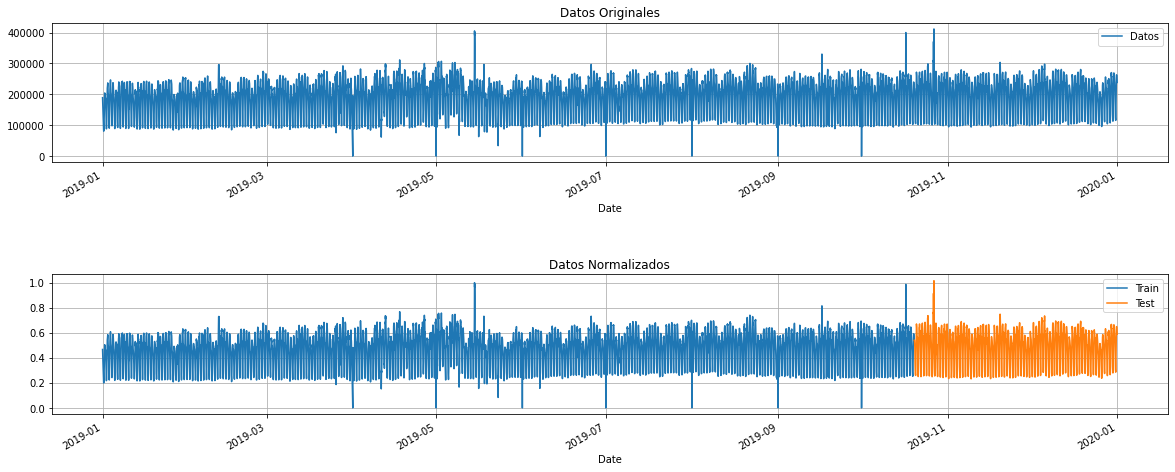

In [11]:
start_month = 'enero'
end_month = 'diciembre'
graphic_1(start_month,end_month,year)
  
# Tabla de resultados
RESULTADOS = pd.DataFrame(columns=['RMSE'])

In [12]:
# Obtener "X" y "y" train y test para las redes neuronales (solo es necesario realizar una vez)
# se trabaja con los datos escalados
n_obs = 20

(X_train, y_train, X_test, y_test) = data_for_rn(train_scaler, test_scaler, n_obs)

print("Dimension de X_train: ", X_train.shape)
print("\nDimension de y_train: ", y_train.shape)
print("\nDimension de X_test: ", X_test.shape)
print("\nDimension de y_test: ", y_test.shape)


Dimension de X_train:  (6976, 20, 1)

Dimension de y_train:  (6976, 1)

Dimension de X_test:  (1729, 20, 1)

Dimension de y_test:  (1729, 1)


## Componentes de la Serie Temporal

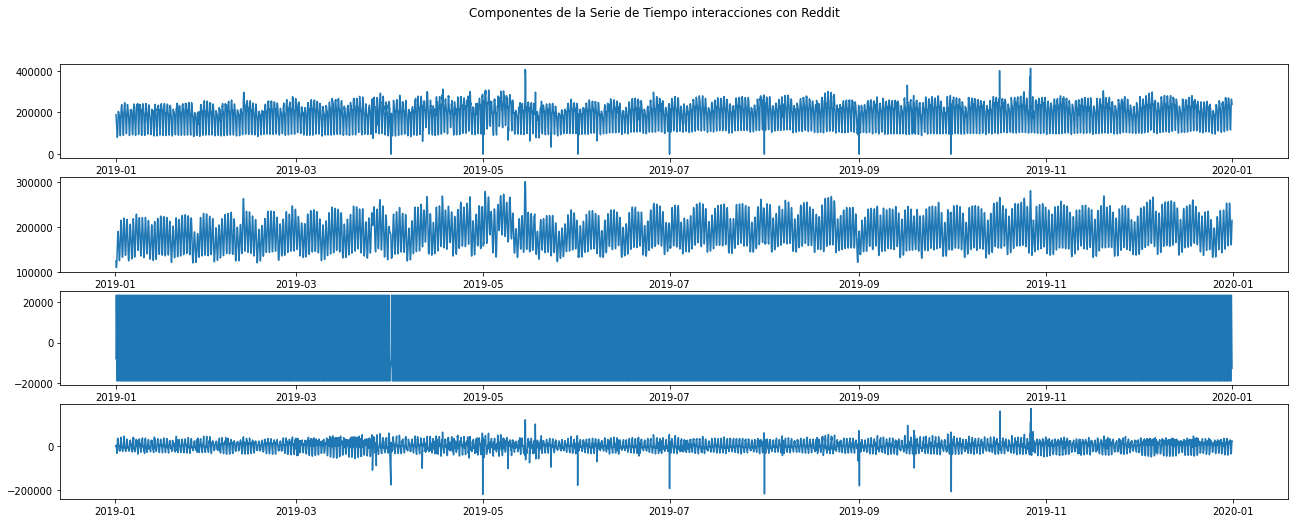

In [13]:
# funcion seasonal_decompose() para observar las 3 componentes de las series de tiempo:
# - Trend
# - Seasonal
# - Resid
components = seasonal_decompose(df_time, model='additive', freq=12) # (df_time)
fig, axs = plt.subplots(4,figsize=(22, 8))
fig.suptitle('Componentes de la Serie de Tiempo interacciones con Reddit')
axs[0].plot(components.observed)
axs[1].plot(components.trend)
axs[2].plot(components.seasonal)
axs[3].plot(components.resid)

## LSTM




In [14]:
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1) # para evatir el overfiting

In [61]:
model_lstm_1 = Sequential()
visible = Input(shape=(X_train.shape[-2:]))
hidden1 = LSTM(64)(visible)
output = Dense(1, activation='linear')(hidden1)
model_lstm_1 = Model(inputs=visible, outputs=output)
model_lstm_1.compile(optimizer='sgd', loss='mean_squared_error')
model_lstm_1.fit(X_train, y_train, batch_size=20, epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop])

# resumen de  capas
model_lstm_1.summary()

Epoch 1/100
349/349 [==============================] - 5s 8ms/step - loss: 0.0222 - val_loss: 0.0174
Epoch 2/100
349/349 [==============================] - 2s 7ms/step - loss: 0.0154 - val_loss: 0.0160
Epoch 3/100
349/349 [==============================] - 2s 7ms/step - loss: 0.0141 - val_loss: 0.0146
Epoch 4/100
349/349 [==============================] - 2s 7ms/step - loss: 0.0130 - val_loss: 0.0135
Epoch 5/100
349/349 [==============================] - 2s 7ms/step - loss: 0.0120 - val_loss: 0.0124
Epoch 6/100
349/349 [==============================] - 2s 7ms/step - loss: 0.0112 - val_loss: 0.0116
Epoch 7/100
349/349 [==============================] - 2s 7ms/step - loss: 0.0105 - val_loss: 0.0109
Epoch 8/100
349/349 [==============================] - 2s 7ms/step - loss: 0.0098 - val_loss: 0.0103
Epoch 9/100
349/349 [==============================] - 2s 7ms/step - loss: 0.0091 - val_loss: 0.0094
Epoch 10/100
349/349 [==============================] - 2s 7ms/step - loss: 0.0085 - val_lo

In [62]:
# red LSTM de 1 capa y 128 Unidades
model_lstm_2 = Sequential()
visible = Input(shape=(X_train.shape[-2:]))
hidden1 = LSTM(128)(visible)
output = Dense(1, activation='linear')(hidden1)
model_lstm_2 = Model(inputs=visible, outputs=output)
model_lstm_2.compile(optimizer='sgd', loss='mean_squared_error')

model_lstm_2.fit(X_train, y_train, batch_size=20, epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop])
# resumen de  capas
model_lstm_2.summary()

Epoch 1/100
349/349 [==============================] - 5s 9ms/step - loss: 0.0194 - val_loss: 0.0161
Epoch 2/100
349/349 [==============================] - 3s 8ms/step - loss: 0.0143 - val_loss: 0.0147
Epoch 3/100
349/349 [==============================] - 3s 8ms/step - loss: 0.0131 - val_loss: 0.0135
Epoch 4/100
349/349 [==============================] - 3s 8ms/step - loss: 0.0121 - val_loss: 0.0126
Epoch 5/100
349/349 [==============================] - 3s 8ms/step - loss: 0.0112 - val_loss: 0.0116
Epoch 6/100
349/349 [==============================] - 3s 8ms/step - loss: 0.0104 - val_loss: 0.0108
Epoch 7/100
349/349 [==============================] - 3s 8ms/step - loss: 0.0097 - val_loss: 0.0100
Epoch 8/100
349/349 [==============================] - 3s 8ms/step - loss: 0.0090 - val_loss: 0.0092
Epoch 9/100
349/349 [==============================] - 3s 8ms/step - loss: 0.0084 - val_loss: 0.0086
Epoch 10/100
349/349 [==============================] - 3s 8ms/step - loss: 0.0079 - val_lo

In [63]:
# red LSTM de 2 capas y 64 unidades

model_lstm_3 = Sequential()
visible = Input(shape=(X_train.shape[-2:]))
hidden1 = LSTM(64, return_sequences=True)(visible)
hidden2 = LSTM(64, return_sequences=False)(hidden1)
output = Dense(1, activation='linear')(hidden2)
model_lstm_3 = Model(inputs=visible, outputs=output)
model_lstm_3.compile(optimizer='sgd', loss='mean_squared_error')
model_lstm_3.fit(X_train, y_train, batch_size=20, epochs=100, # verbose = 0
                 validation_data=(X_test, y_test),
                    callbacks=[early_stop]) 
# resumen de  capas
model_lstm_3.summary()

Epoch 1/100
349/349 [==============================] - 9s 15ms/step - loss: 0.0210 - val_loss: 0.0201
Epoch 2/100
349/349 [==============================] - 5s 13ms/step - loss: 0.0179 - val_loss: 0.0190
Epoch 3/100
349/349 [==============================] - 5s 13ms/step - loss: 0.0172 - val_loss: 0.0182
Epoch 4/100
349/349 [==============================] - 5s 13ms/step - loss: 0.0166 - val_loss: 0.0176
Epoch 5/100
349/349 [==============================] - 5s 13ms/step - loss: 0.0160 - val_loss: 0.0169
Epoch 6/100
349/349 [==============================] - 5s 13ms/step - loss: 0.0153 - val_loss: 0.0160
Epoch 7/100
349/349 [==============================] - 5s 13ms/step - loss: 0.0145 - val_loss: 0.0149
Epoch 8/100
349/349 [==============================] - 4s 13ms/step - loss: 0.0137 - val_loss: 0.0141
Epoch 9/100
349/349 [==============================] - 5s 13ms/step - loss: 0.0128 - val_loss: 0.0128
Epoch 10/100
349/349 [==============================] - 5s 13ms/step - loss: 0.012

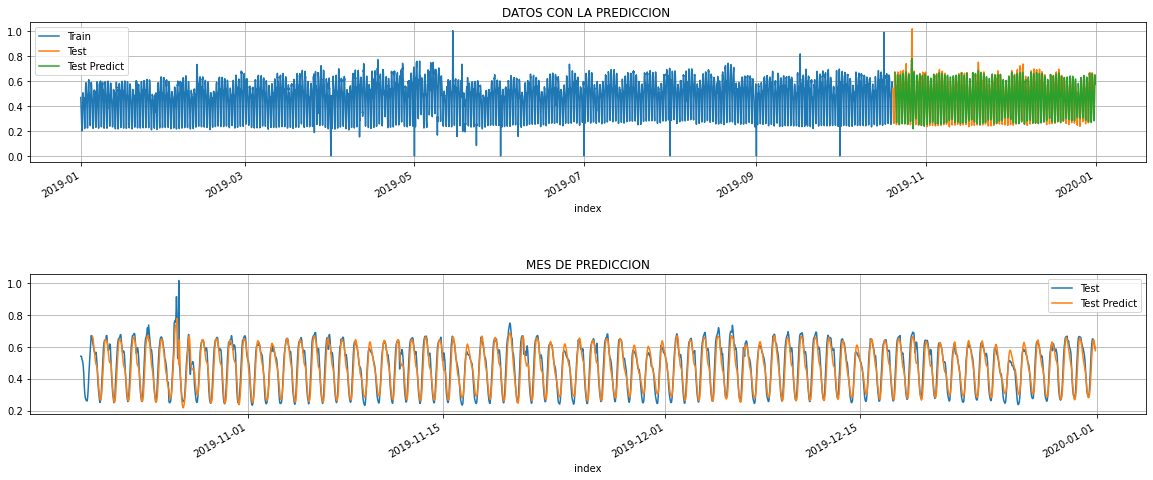

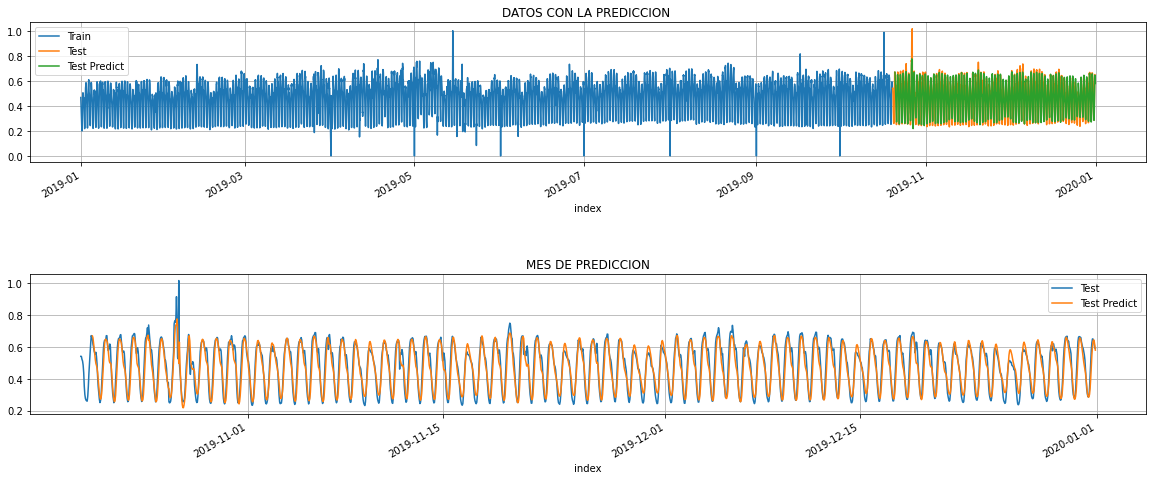

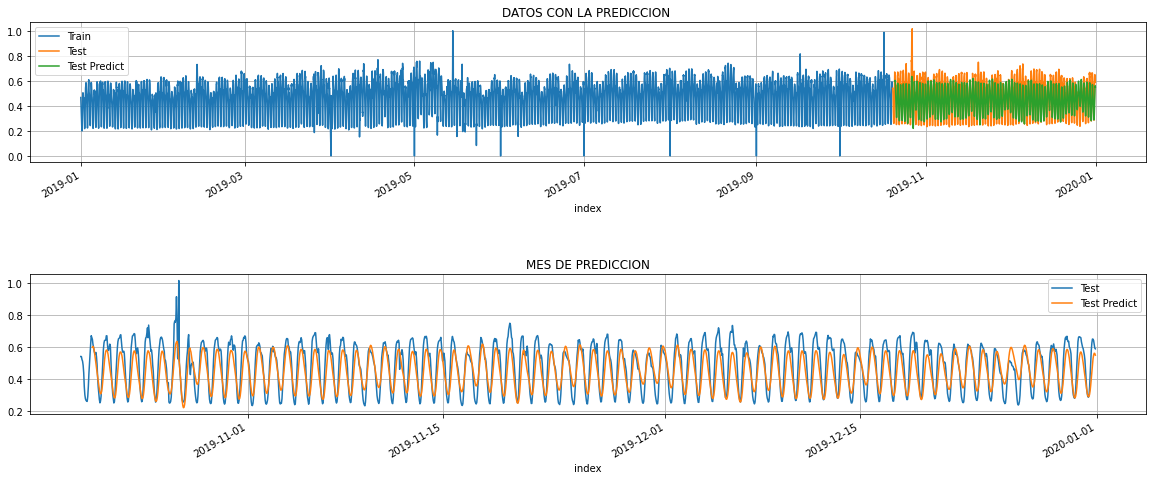

In [64]:
prediction(model_lstm_1, X_test)
prediction(model_lstm_2, X_test)
prediction(model_lstm_3, X_test)

## GRU

In [65]:
modelo_gru_1 = Sequential()
modelo_gru_1.add(Input(shape=(X_train.shape[-2:])))
modelo_gru_1.add(GRU(units=64, activation='linear')) #tanh, se quito el return_sequences=True
modelo_gru_1.add(Dense(units=1))
modelo_gru_1.compile(optimizer='sgd',loss='mean_squared_error')
modelo_gru_1.fit(X_train,y_train,epochs=100,batch_size=20,
               validation_data=(X_test, y_test),
                    callbacks=[early_stop])

# resumen de  capas
modelo_gru_1.summary()

Epoch 1/100
349/349 [==============================] - 24s 65ms/step - loss: 0.0152 - val_loss: 0.0117
Epoch 2/100
349/349 [==============================] - 22s 64ms/step - loss: 0.0096 - val_loss: 0.0092
Epoch 3/100
349/349 [==============================] - 22s 64ms/step - loss: 0.0080 - val_loss: 0.0081
Epoch 4/100
349/349 [==============================] - 22s 64ms/step - loss: 0.0071 - val_loss: 0.0072
Epoch 5/100
349/349 [==============================] - 23s 65ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 6/100
349/349 [==============================] - 22s 64ms/step - loss: 0.0062 - val_loss: 0.0062
Epoch 7/100
349/349 [==============================] - 23s 66ms/step - loss: 0.0059 - val_loss: 0.0060
Epoch 8/100
349/349 [==============================] - 23s 65ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 9/100
349/349 [==============================] - 23s 65ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 10/100
349/349 [==============================] - 22s 63ms/step - l

In [66]:
# Red GRU de 1 capa con 128 unidades
modelo_gru_2 = Sequential()
modelo_gru_1.add(Input(shape=(X_train.shape[-2:])))
modelo_gru_2.add(GRU(units=128, activation='linear')) 
modelo_gru_2.add(Dense(units=1))
modelo_gru_2.compile(optimizer='sgd',loss='mean_squared_error')
modelo_gru_2.fit(X_train,y_train,epochs=100,batch_size=20,
                 validation_data=(X_test, y_test), #verbose=0
                    callbacks=[early_stop])
# resumen de  capas
modelo_gru_2.summary()

Epoch 1/100
349/349 [==============================] - 24s 65ms/step - loss: 0.0190 - val_loss: 0.0136
Epoch 2/100
349/349 [==============================] - 23s 65ms/step - loss: 0.0111 - val_loss: 0.0106
Epoch 3/100
349/349 [==============================] - 22s 64ms/step - loss: 0.0091 - val_loss: 0.0087
Epoch 4/100
349/349 [==============================] - 22s 64ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 5/100
349/349 [==============================] - 23s 65ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 6/100
349/349 [==============================] - 22s 63ms/step - loss: 0.0065 - val_loss: 0.0065
Epoch 7/100
349/349 [==============================] - 23s 66ms/step - loss: 0.0061 - val_loss: 0.0061
Epoch 8/100
349/349 [==============================] - 23s 65ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 9/100
349/349 [==============================] - 23s 65ms/step - loss: 0.0056 - val_loss: 0.0057
Epoch 10/100
349/349 [==============================] - 23s 65ms/step - l

In [67]:
# Red GRU de 2 capa con 64 unidades

modelo_gru_3 = Sequential()
modelo_gru_3.add(GRU(units=64, return_sequences=True, input_shape=(X_train.shape[-2:]), activation='linear')) 
modelo_gru_3.add(GRU(units=64, return_sequences=False, input_shape=(X_train.shape[1],1), activation='tanh'))
modelo_gru_3.add(Dense(units=1))
modelo_gru_3.compile(optimizer='sgd',loss='mean_squared_error')
modelo_gru_3.fit(X_train,y_train,epochs=100,batch_size=20,
                 validation_data=(X_test, y_test), #verbose=0
                    callbacks=[early_stop])
# resumen de  capas
modelo_gru_3.summary()

Epoch 1/100
349/349 [==============================] - 27s 68ms/step - loss: 0.0187 - val_loss: 0.0154
Epoch 2/100
349/349 [==============================] - 23s 66ms/step - loss: 0.0136 - val_loss: 0.0136
Epoch 3/100
349/349 [==============================] - 23s 66ms/step - loss: 0.0122 - val_loss: 0.0124
Epoch 4/100
349/349 [==============================] - 23s 67ms/step - loss: 0.0112 - val_loss: 0.0117
Epoch 5/100
349/349 [==============================] - 23s 66ms/step - loss: 0.0104 - val_loss: 0.0107
Epoch 6/100
349/349 [==============================] - 23s 67ms/step - loss: 0.0098 - val_loss: 0.0101
Epoch 7/100
349/349 [==============================] - 23s 66ms/step - loss: 0.0092 - val_loss: 0.0095
Epoch 8/100
349/349 [==============================] - 23s 67ms/step - loss: 0.0087 - val_loss: 0.0089
Epoch 9/100
349/349 [==============================] - 23s 66ms/step - loss: 0.0082 - val_loss: 0.0084
Epoch 10/100
349/349 [==============================] - 23s 66ms/step - l

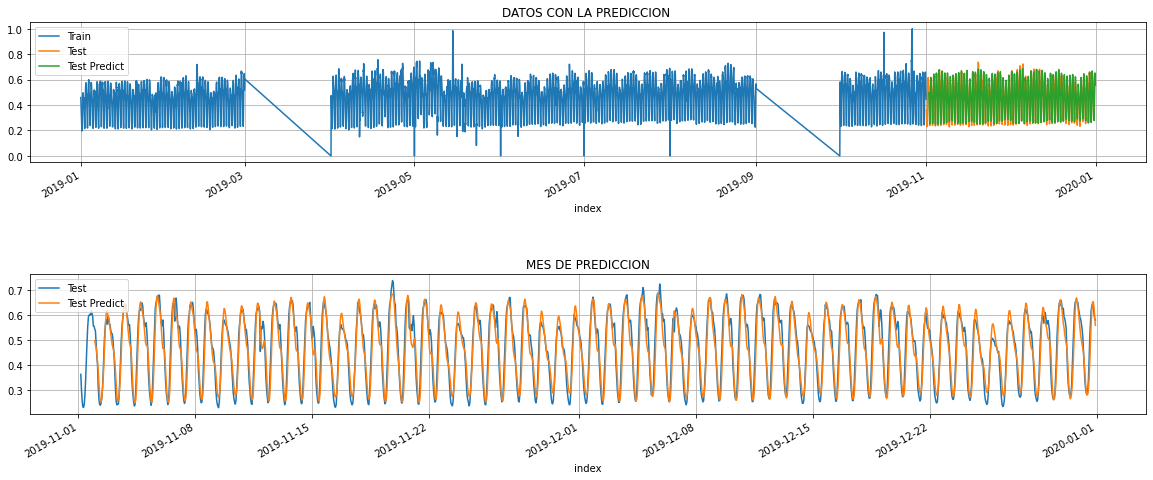

In [47]:
prediction(modelo_gru_1, X_test)
prediction(modelo_gru_2, X_test)
prediction(modelo_gru_3, X_test)

In [48]:
RESULTADOS

,RMSE
Modelo 1 capa lstm-64,0.046772
Modelo 1 capa lstm-128,0.045904
Modelo 2 capas lstm64+lstm-64,0.073069
Modelo 1 capa dense-64,0.031772
Modelo 1 capa gru-64,0.042866
Modelo 1 capa gru-128,0.030853
Modelo 2 capas gru64+gru-64,0.042866


## TCN

In [1]:
# para trabajo con redes convolucionales temporales

!pip install keras-tcn

     |████████████████████████████████| 1.1 MB 4.1 MB/s 


In [2]:
from tcn import TCN, tcn_full_summary
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.models import Input, Model

from tcn import TCN

In [15]:
i = Input(shape=(X_train.shape[1], 1))
m = TCN(nb_filters=64, kernel_size=3, nb_stacks=1, dilations=(1, 2, 4, 8, 16, 32),
        padding='causal',activation='relu')(i)
m = Dense(1, activation='linear')(m)

model_tcn = Model(inputs=[i], outputs=[m])
model_tcn.compile(optimizer='adam', loss='mse')
model_tcn.fit(X_train, y_train, epochs=100, batch_size=20,
              validation_data=(X_test, y_test),
                    callbacks=[early_stop])

model_tcn.summary()

Epoch 1/100
349/349 [==============================] - 37s 18ms/step - loss: 0.1482 - val_loss: 0.0014
Epoch 2/100
349/349 [==============================] - 5s 16ms/step - loss: 0.0014 - val_loss: 9.3986e-04
Epoch 3/100
349/349 [==============================] - 6s 16ms/step - loss: 0.0012 - val_loss: 9.2880e-04
Epoch 4/100
349/349 [==============================] - 6s 16ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 5/100
349/349 [==============================] - 5s 15ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 6/100
349/349 [==============================] - 6s 16ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 7/100
349/349 [==============================] - 5s 16ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 00007: early stopping
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 1)]           0         
____________________________________

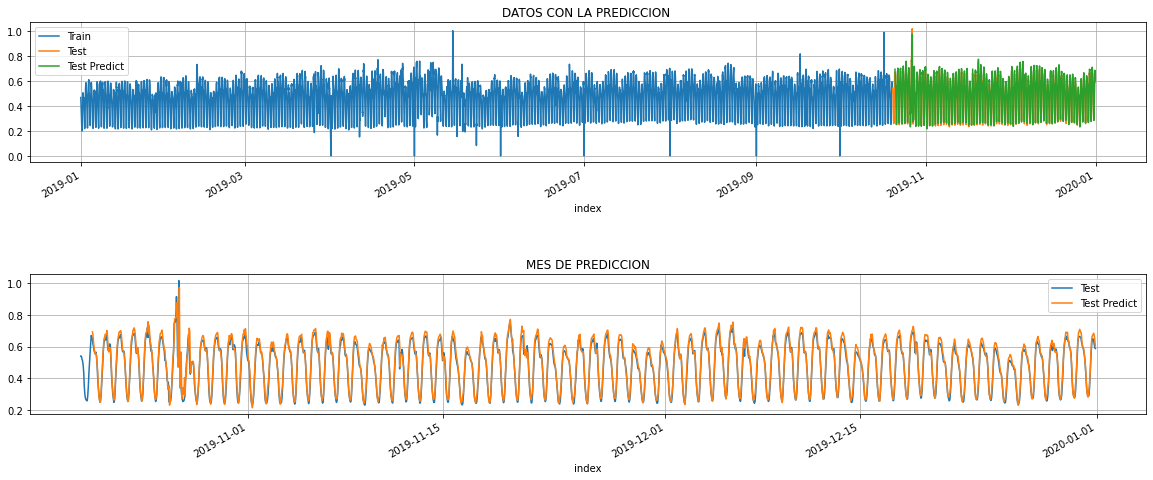

In [16]:
prediction(model_tcn, X_test)

In [17]:
RESULTADOS

,RMSE
Modelo 1 capa tcn-64,0.03217


## CNN - LSTM

In [19]:
# Librerias para la convinacion CNN-LSTM

from keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten

In [26]:
n_steps, n_length = 2, 10
X_train_cnn_lstm = X_train.reshape((X_train.shape[0], n_steps, n_length, X_train.shape[2]))
X_test_cnn_lstm = X_test.reshape((X_test.shape[0], n_steps, n_length, X_train.shape[2]))

In [29]:

model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,1)))
#model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model_cnn_lstm.add(TimeDistributed(Dropout(0.5)))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(64))
model_cnn_lstm.add(Dropout(0.5))
model_cnn_lstm.add(Dense(1, activation='relu'))
model_cnn_lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model_cnn_lstm.fit(X_train_cnn_lstm, y_train, epochs=100, batch_size=20, #, verbose=verbose)
                  validation_data=(X_test_cnn_lstm, y_test),
                    callbacks=[early_stop])

model_cnn_lstm.summary()

Epoch 1/100
349/349 [==============================] - 5s 8ms/step - loss: 0.0174 - mse: 0.0174 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 2/100
349/349 [==============================] - 2s 7ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0130 - val_mse: 0.0130
Epoch 3/100
349/349 [==============================] - 2s 6ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 4/100
349/349 [==============================] - 2s 6ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 5/100
349/349 [==============================] - 2s 7ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 6/100
349/349 [==============================] - 2s 6ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 7/100
349/349 [==============================] - 2s 6ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 8/100
349/349 [==============================] - 2s 7ms/step - 

In [32]:
model_cnn_lstm.layers[0].get_output_shape_at(0)

(None, None, 8, 64)

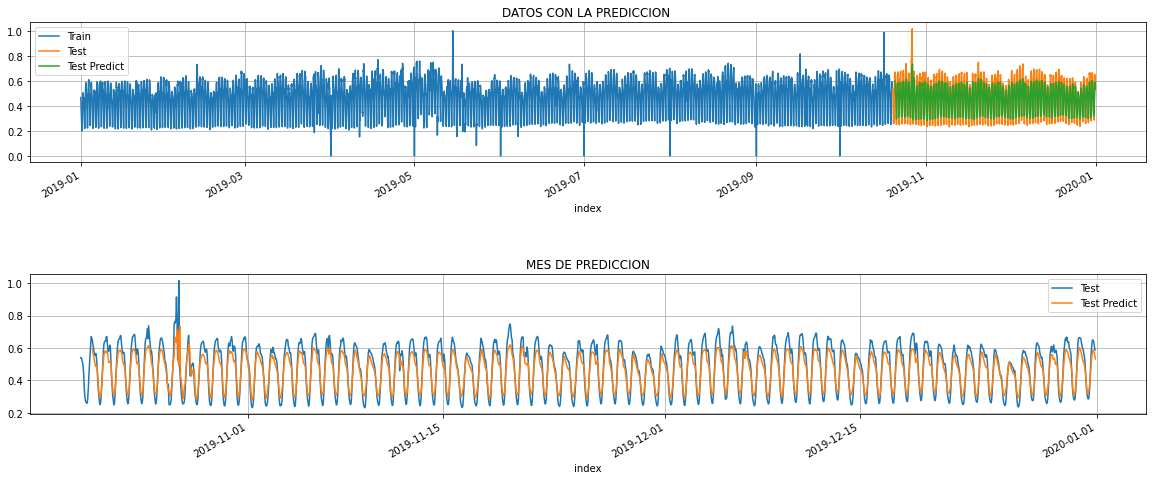

In [48]:
prediction(model_cnn_lstm, X_test_cnn_lstm)

In [49]:
RESULTADOS

,RMSE
Modelo 1 capa tcn-64,0.032170
Modelo time-64+dropout-None,0.054737
Modelo cnn -64+lstm-None,0.054737
Modelo cnn -64+lstm-4,0.054737
Modelo cnn -64+lstm-64,0.054737
